# Dynamisches Prozessmodell mit der DIM-Toolbox

Ziel des Tutorials ist den Workflow zur Identifikation eines statischen Prozessmodells für den Spritzgießprozess mit der DIM-Toolbox zu veranschaulichen.

Die für das Modelltraining (Schätzung der Modellparameter) und die Modellvalidierung verwendeten Daten wurden im Rahmen eines umfangreichen Versuchsplanes erhoben. Der Trainingsdatensatz umfasst die Daten von 2105 Produktionszyklen, der Validierungsdatensatz umfasst die Daten von 548 Produktionszyklen.

In [1]:
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import sys
sys.path.insert(0, "/home/alexander/GitHub/DigitalTwinInjectionMolding/")
sys.path.insert(0, 'E:/GitHub/DigitalTwinInjectionMolding/')

from DIM.models.model_structures import GRU
from DIM.models.injection_molding import QualityModel
from DIM.optim.param_optim import ModelTraining, parallel_mode
from DIM.miscellaneous.PreProcessing import LoadDynamicData
from DIM.optim.common import BestFitRate

Spezifiziere Pfad zur Datenbasis und welche Chargen für Modellbildung und -validierung verwendet werden sollen 

In [3]:
path = 'E:/GitHub/DigitalTwinInjectionMolding/data/Versuchsplan/normalized/'
charges = list(range(1,275))
split = 'all' 
mode='quality'  # 'process'

Spezifiziere Ein- und Ausgangsgrößen für die Submodelle des Qualitätsmodells sowie die Dimenion der internen Modellzustände. Alle Submodelle müssen dieselbe Anzahl an internen Modellzuständen haben.

In [4]:
u_inj= ['p_wkz_ist','T_wkz_ist']
u_press= ['p_wkz_ist','T_wkz_ist']
u_cool= ['p_wkz_ist','T_wkz_ist']

u_lab = [u_inj,u_press,u_cool]

y_lab = ['Durchmesser_innen']

dim_c = 9

Die Funktion LoadDynamicData() geht die zyklenweise abgelegten Dateien durch und liest alle Prozessdaten aus sowie die korrespondierenden Qualitätsdaten und teilt die Daten anschließend in Trainings- und Validierungsdaten ein

In [5]:
data_train,data_val = LoadDynamicData(path,charges,split,y_lab,u_lab,mode)

In [ ]:
print(data_train.keys())

Für Modelle mit interner Dynamik muss der initiale Zustand vom Nutzer festgelegt werden. Dieser wird standardmäßig auf Null gesetzt, was im Kontext dieser Anwendung ebenfalls sinnvoll ist:

In [6]:
c0_train = [np.zeros((dim_c,1)) for i in range(0,len(data_train['data']))]
c0_val = [np.zeros((dim_c,1)) for i in range(0,len(data_val['data']))] 

data_train['init_state'] = c0_train
data_val['init_state'] = c0_val

Die Daten werden von LoadDynamicData() automatisch skaliert. Plotte eine Untermenge der Validerungsdaten zu Visualisierungszwecken

<AxesSubplot:ylabel='Durchmesser_innen'>

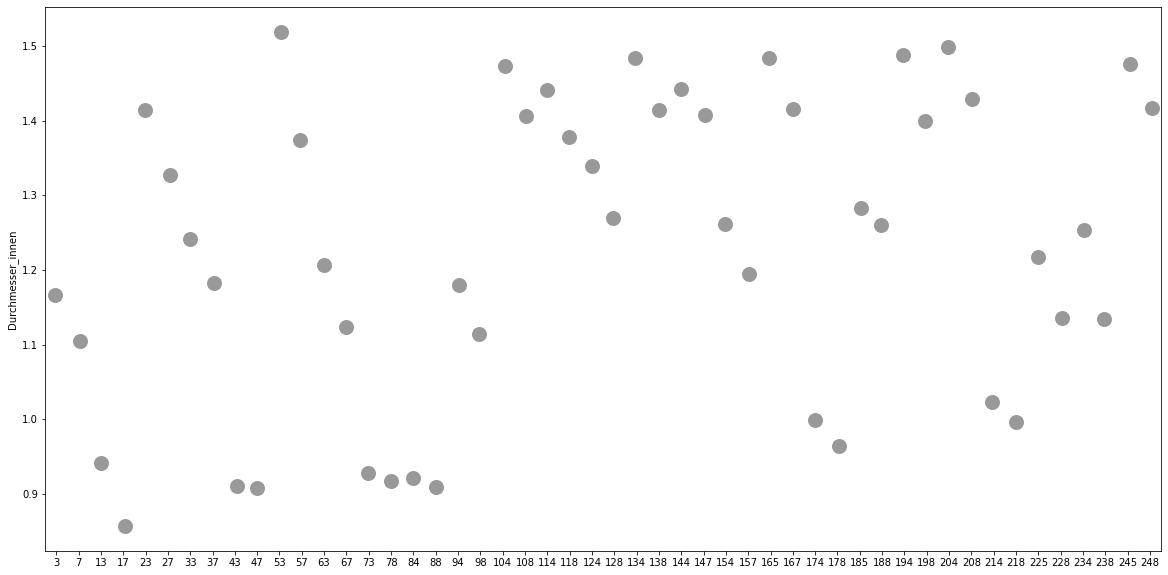

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))

data_val_plot = pd.DataFrame(data=[c.loc[0,'Durchmesser_innen'] for c in data_val['data']],
                            index = data_val['cycle_num'],
                            columns=['Durchmesser_innen'])

idx_plot = data_val_plot.index[0:50]

sns.stripplot(x=idx_plot,y=data_val_plot.loc[idx_plot,'Durchmesser_innen'],color='grey',alpha=.8,size=15,ax=ax)

Implementierte rekurrente Modellstrukturen sind LSTM und GRU. Das GRU hat in Experimenten bessere Ergebnisse geliefert und besitzt zudem weniger Modellparameter. Bei der Erzeugung einer Instanz der Klasse GRU müssen einige Parameter festgelegt werden:

| Parameter | Typ | Erläuterung |
| --- | --- | :-- |
|dim_u : |int |Anzahl an Modelleingängen |
|dim_c : |int |Anzahl an internen Modellzuständen |
|dim_hidden | int | Anzahl an Neuronen in der verdeckten Schicht des MLPs welches die Ausgabegleichung approximiert |
|dim_out | int | Anzahl der Modellausgänge |
|u_label| list of str |Namen der Eingangsgrößen, muss mit den Spaltenüberschriften in data_train, data_val übereinstimmen|
|y_label| list of str |Namen der Ausgangsgrößen, muss mit den Spaltenüberschriften in data_train, data_val übereinstimmen|
|name | str | Name des Modells, wird verwendet, um Modellparameter eindeutig zu identifizieren und bspw. von den Parametern anderer Instanzen der gleichen Klasse zu unterscheiden|

Für jedes Submodell muss eine eigene Instanz der Klasse GRU() erzeugt werden, nur dann sind die Modellparameter der Submodelle wirklich verschieden voneinander.

In [8]:
inj_model = GRU(dim_u=2,dim_c=dim_c,dim_hidden=1,
                u_label=u_inj,y_label=y_lab,dim_out=1,name='inj')

press_model = GRU(dim_u=2,dim_c=dim_c,dim_hidden=1,
                  u_label=u_press,y_label=y_lab,dim_out=1,name='press')

cool_model = GRU(dim_u=2,dim_c=dim_c,dim_hidden=10,
                  u_label=u_cool,y_label=y_lab,dim_out=1,name='cool')

Bei rekurrenten Modellen ist die Initialisierung der Modellparameter besonders wichtig, um ein gutes Optimierungsergebnis zu erzielen. Im Falle der Modellarchitektur GRU ist es vorteilhaft, den Bias des Update-Gates mit betragsmäßig großen negativen Werten zu initialisieren:

In [11]:
press_model.InitialParameters ={'b_z_press':np.random.uniform(-10,-4,(dim_c,1))}
cool_model.InitialParameters = {'b_z_cool':np.random.uniform(-10,-4,(dim_c,1))}

Die Submodelle werden nun in einer Instanz der Klasse QualityModel() gesammelt. Diese Klasse stellt Methoden zur Verfügung, die ermöglichen, dass zwischen den Submodellen zum richtigen Zeitpunkt umgeschaltet wird, der interne Zustand übergeben wird, usw. 

In [13]:
model_q = QualityModel(subsystems=[inj_model,press_model,cool_model],
                              name='q_model')

Das Modell model_q kann nun wie gewohnt an die Methode ModelTraining() übergeben werden, um die Parameter zu schätzen.

Die Routine ModelTraining() erhält als Argument das zu optimierende Modell, Trainings- und Validierungsdaten, wie oft das Optimierungsproblem neu initialisiert und gelöst werden soll (nichtlineares Optimierungsproblem) sowie den Modus der Modellauswertung:

| Parameter | Typ | Erläuterung |
| --- | --- | :-- |
|model : | DIM.models | Zu optimierendes Modell |
|data_train | pd.DataFrame | Trainingsdaten mit Beobachtungen in den Zeilen und Eingangs- / Ausgangsgrößen in den Spalten |
|data_val| pd.DataFrame | Trainingsdaten mit Beobachtungen in den Zeilen und Eingangs- / Ausgangsgrößen in den Spalten |
|initializations| int | Anzahl der Multistarts, i.e. wie oft die Parameter zufällig neu initialisiert und das Optimierungsproblem von vorne gelöst werden soll|
|p_opts | dict | printing Optionen für CasADi, siehe https://web.casadi.org/docs/ |
|s_opts | dict | An IPOPT zu übergebende Parameter, siehe https://coin-or.github.io/Ipopt/OPTIONS.html |
|mode | str | Art der Modellauswertung, es wird unterschieden zwischen 'parallel', 'static' und 'series'|

In [14]:
# results_q = ModelTraining(model_q,data_train,data_val,initializations=10,
#                           p_opts=None,s_opts=None,mode='static')

Für gewöhnlich müssen einige Multistarts ausgeführt werden (mindestens 10). Für dieses Tutorial werden aus Zeitgründen die Ergebnisse von bereits durchgeführten Optimierungsdurchläufen geladen.

In [15]:
result_q = pkl.load(open('GRU_c9_3sub_all.pkl','rb'))

ModelTraining() gibt einen Pandas DataFrame zurück. Dieser enthält den Wert der Kostenfunktion des Modells jeweils auf den Trainings- und Validierungsdaten sowie die zugehörigen Modellparameter.

In [17]:
print(result_q)

       loss_train  loss_val    model  \
0    3.286233e+00    0.9849  q_model   
1   2.222281e+307  1.224618  q_model   
2    3.400153e+98  1.217712  q_model   
3   1.058231e+123  1.290329  q_model   
4   1.500945e+201  1.024891  q_model   
5    4.615113e+04  2.347293  q_model   
6    3.140620e+00  0.771558  q_model   
7    4.299764e+00  1.121796  q_model   
8    7.824558e+00  1.756377  q_model   
9   1.098146e+104  2.741785  q_model   
10   3.146446e+00  0.749514  q_model   
11   1.198504e+63  2.098423  q_model   
12   3.816781e+00  1.071435  q_model   
13   5.849058e+46  1.562786  q_model   
14   1.686442e+01  1.290315  q_model   
15   2.394431e+01   1.12851  q_model   
16   5.945596e+00  1.258171  q_model   
17  5.556427e+187  1.507651  q_model   
18   4.519485e+55  1.787059  q_model   
19   7.884649e+00  1.657222  q_model   

                                         params_train  \
0   {'W_r_inj': [[0.15272906322459542, -0.11465043...   
1   {'W_r_inj': [[4.647696244939242e+149, 9.4

Die Instanzen der Klasse GRU selbst sind noch unverändert. Die neuen Parameter müssen dem Modell erst noch zugewiesen werden. Die Klasse QualityModel() stellt dafür die Methode SetParameters() bereit

In [18]:
params = result_q.loc[10]['params_val']

#model_q.Parameters = result_q.loc[10]['params_val'] # funktioniert nicht

model_q.SetParameters(params)

Das statische Prozessmodell model_p beschreibt nun die Abbildung der an der Maschine eingestellten Prozessparameter auf die resultierenden Features. Das Modell mit den optimierten Parametern kann nun bspw. auf den Validerungsdaten (oder Daten des laufenden Betriebs) ausgewertet werden. Die Funktion static_mode() wertet ein statisches Modell auf einem gegebenen Datensatz aus.

In [19]:
_,prediction_q = parallel_mode(model_q,data_val)

Um die Modellgüte zu beurteilen kann die Best Fit Rate berechnet werden:

In [20]:
prediction_q_plot = pd.DataFrame(data=[c['Durchmesser_innen'].values for c in prediction_q],
                                index = data_val['cycle_num'],
                                columns=['Durchmesser_innen'])


print(BestFitRate(data_val_plot[y_lab].values, prediction_q_plot[y_lab].values))

91.31701641994556


Durch Gegenüberstellung der bekannten wahren Bauteilqualität mit der prädizierten Bauteilqualität kann das Ergebnis visualisiert werden:

<AxesSubplot:ylabel='Durchmesser_innen'>

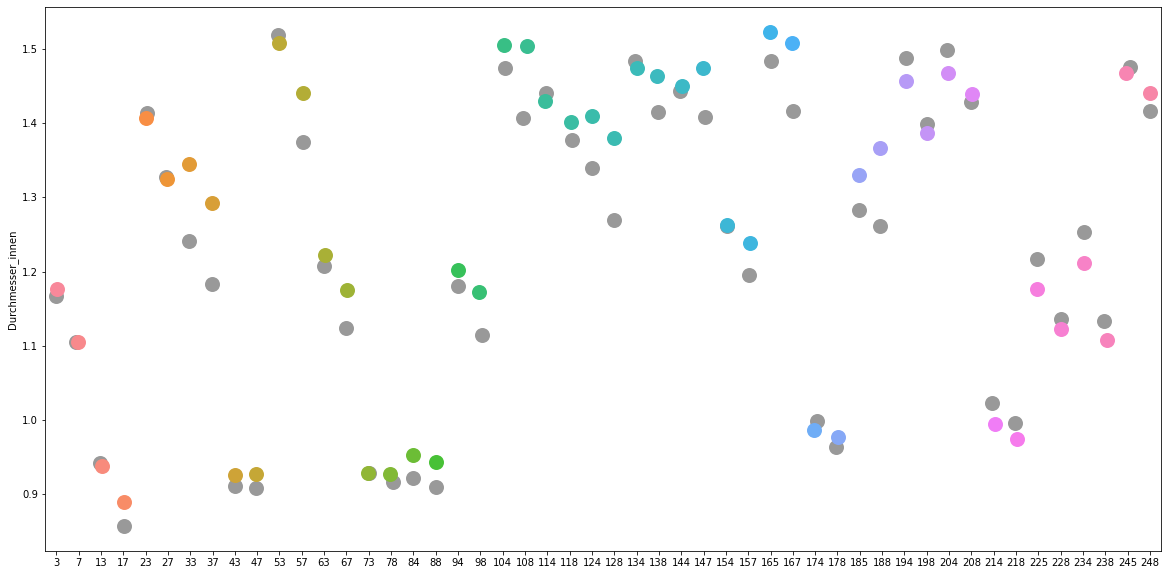

In [21]:
fig, ax = plt.subplots(figsize=(20, 10))
sns.stripplot(x=idx_plot,y=data_val_plot.loc[idx_plot,'Durchmesser_innen'],color='grey',alpha=.8,
              size=15,ax=ax)
sns.stripplot(x=idx_plot,y=prediction_q_plot.loc[idx_plot,'Durchmesser_innen'],size=15,ax=ax)